In [1]:

from Bio import SeqIO, AlignIO, Phylo
from Bio.SeqRecord import SeqRecord
import Bio.Align
from Bio.Align.AlignInfo import SummaryInfo
from Bio.Seq import Seq
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp


In [2]:
#complete these variables with the input files directory 

dog_breeds = r"/workspaces/Coursework-Identify-the-most-similar-sequence-/data/dog_breeds.fa"
mystery_breed = r"/workspaces/Coursework-Identify-the-most-similar-sequence-/data/mystery.fa"
output = r"/workspaces/Coursework-Identify-the-most-similar-sequence-/results"
ind_breeds = r"/workspaces/Coursework-Identify-the-most-similar-sequence-/results/individual_breed_sequences"

In [3]:
class Breed():
    """This class stores information about every breed and their sequence"""
    #create a list to store all instances of the class
    all_instances = []
    #define an init function which stores the sequence as a sequence object, the breed as a string and the fasta format of the sequence
    def __init__(self, sequence, breed, fasta):
        self.sequence = sequence
        self.breed = breed
        self.fasta = fasta
        #store all initialised instances in the defined list
        Breed.all_instances.append(self) 


In [4]:
#open the fasta file and save the sequence breed and sequence name in a Breed Class to be accessed later
def read_fasta(filename = dog_breeds, format = "fasta"):
    #parse through the dog_breeds file
    for record in SeqIO.parse(filename, format):
        #get the description of each sequence to find out what breed it is 
        #split the description on "[" as these are used to separate each descriptor
        for key in list(record.description.split("[")): 
            #if the keyword breed is in the description but the keyword "isolate" is not in thr description it will define the dog breed 
            if "breed" in key and "isolate" not in key:
                #each sequence in filename gets assigned a name based on the breed identified in the desciption
                #intialises an object of class Breed which contains the sequence, breed name and the full record 
                record.name = Breed(record.seq, (key[6:-2]).capitalize(), record)
#call the function
read_fasta()

In [5]:
#set up a list that contains all unique breed names in a list
all_breeds = set()
#itterate through all instances in Breed class
for key in Breed.all_instances:
    #access and add every breed to the all_breeds set
    all_breeds.add(key.breed)

#write a fasta file containing all sequences that belong to the same breed 
#set up directory where files will be created
os.chdir(ind_breeds) 
for breed in all_breeds:
    #creates a temporary variable corresponding to each individual dog breed 
    temp = breed
    #creates a filename eith the name of the breed in a writable format
    file = open(breed, "w") 
    #itterate throough all instances of the class Breed
    for key in Breed.all_instances: 
        #check if the breedd is the same as the current breed in the loop stored in the temp variable 
        if key.breed == temp:
            #adds the sequence to the file that was created before 
            SeqIO.write(key.fasta, file, "fasta") 
    #once all the sequences in the same breed are added to the file  it is closed
    file.close() 


In [6]:
def concensus_seq(filename):
    """Function that takes in a file containing a number of sequences and returns a concensus sequence"""
    #align all the sequences in each file
    alignments = AlignIO.parse(filename, "fasta") 
    #assign filename to varible recordname which will be used to create a name for this record 
    recordname = f"{filename}" 
    for alignment in alignments: 
        #get summary info of each alignment to create a concensus 
        summary = SummaryInfo(alignment) 
        #create a concensus of each alignmernt 
        consensus = summary.dumb_consensus() 
        #create a fasta format sequence using the consensus sequence and recordname
        seq_record = SeqRecord(Seq(consensus), id=recordname) 
        #add each concensus seq to a list 
    return seq_record

#create a consensus sequence for each breed 
#store the concensus sequences in a fasta format 
consensus_sequences = [] 
#set directory to where the sequences are 
os.chdir(ind_breeds) 
#open each file created in the previous step 
for file in all_breeds:
    #run the concensus_seq function to get the concensus file of each breed in the concensus list 
    consensus_sequences.append(concensus_seq(file))


/workspaces/Coursework-Identify-the-most-similar-sequence-/.coursework/lib/python3.10/site-packages/Bio/Align/AlignInfo.py:63: BiopythonDeprecationWarning: The `dumb_consensus` method is deprecated and will be removed in a future release of Biopython. As an alternative, you can convert the multiple sequence alignment object to a new-style Alignment object by via its `.alignment` property, and then create a Motif object. You can then use the `.consensus` or `.degenerate_consensus` property of the Motif object to get a consensus sequence. For more control over how the consensus sequence is calculated, you can call the `calculate_consensus` method on the `.counts` property of the Motif object. This is an example for a multiple sequence alignment `msa` of DNA nucleotides:
>>> from Bio.Seq import Seq
>>> from Bio.SeqRecord import SeqRecord
>>> from Bio.Align import MultipleSeqAlignment
>>> from Bio.Align.AlignInfo import SummaryInfo
>>> msa = MultipleSeqAlignment([SeqRecord(Seq('ACGT')),
..

In [7]:
#SHOULD THIS BE A FUNCTION TO ALLOW USER ENTRY OF TARGET SEQUENCE INSTEAD?


#get sequence from file 
unknown_sequence = SeqIO.read(mystery_breed, "fasta") 
#add mystery sequence to the concensus file list 
consensus_sequences.append(SeqRecord(unknown_sequence.seq, id="mystery_sequence"))

#store concensus sequences in a results folder in a file called concensus_sequences
concensus_filename = f"{output}/concensus_sequences"  
with open(concensus_filename, "w"):
        #adds the sequence to the file in a fasta format
        SeqIO.write(consensus_sequences, concensus_filename, "fasta") 


In [8]:
def alignment(n, mystery_sequence = mystery_breed, breed_seqs =consensus_sequences):
    """Takes in index number of the alignment score (1 being the top scoring sequence), an unknown sequence (predifined) 
    and compares it to the database(predifined) to return the nth alignment.
    n is the only required paramater, mystery_sequence and breed_seeqs can be substituted with a different dataset otherwise 
    defoult database will be used"""
    #set a variable to store scores of each alignment
    all_scores = []
    #open the target sequence file and save its sequence in the unknown_sequence variable 
    for record in SeqIO.parse(mystery_sequence, "fasta"): 
        unknown_sequence = record.seq
    #Create a pairwise alignment varaible 
    aligner = Bio.Align.PairwiseAligner() 
    #itterate through the sequences saved in the breed concensus sequences file 
    for record in breed_seqs: 
        #find the score of each alignment and save it in the all_scores list 
        score = aligner.score(record.seq, unknown_sequence) 
        all_scores.append(score)
    #sort the alignment scores from highest to lowest  
    all_scores.sort(reverse=True)
    #get the n'th alignment score 
    target_score = all_scores[n]
    #itterate through sequences in the breed_seqs again 
    for record in breed_seqs:
        #create an alignment between the mystery sequence and the brred conceensus sequence only if the alignment has the target score
        if aligner.score(record.seq, unknown_sequence) == target_score:
            #store the alignemnt
            alignment = aligner.align(record.seq, unknown_sequence)
            #store and return information about the nth alignemnt [breed name, sequence of the breed, alignment of the breed and target sequence and the score of the alignemnt]
            breed_score = (record.id).replace("_consensus", ""), record.seq, alignment[0], target_score
    return breed_score

In [9]:
def percentage_similarity(aln):
    """Given a pairwise alignment calculates the percentage similarity between the two sequences"""
    #create a varieble to store the instances where columns are identical
    identical_columns = float()
    #itterate through every column of the alignment
    for a in range(len(aln[0])): 
        #check if first and second sequence is the same at point a, a describing the column 
        if aln[0,a] == aln[1,a]: 
            #if base at position a is the same in both sequences add 1 to the amount of identical columns 
            identical_columns += 1
    #calculate the percentage based on the identical columns number and the length of the alignment 
    percentage = 100 * identical_columns / float(len(aln[0])) 
    #return percentage to 3dp
    return  round(percentage,3) 

In [10]:
#calculate percentage similarity of the top scoring sequence 
top_percentage = percentage_similarity((alignment(0)[2]))
#set variable to hold the top alignment and its details 
full_top_alignment = alignment(0)
#set a variable to just hold the top alignemnt without the rest of the details 
top_alignment = full_top_alignment[2]

In [11]:
#create a directory for the top alignment file 
filename = f"{output}/top_alignment_output"  
#create a file to store the top scoring alignment as clustal file 
with open(filename, "w"):
        Bio.Align.write(top_alignment, filename, "clustal")


In [12]:
#get results aka the breed, its sequence and percentage similarity 
results = "The breed most similar to the mustery DNA file is the", full_top_alignment[0], "its percent identity is", top_percentage, "% and the breeds consensus sequence is:", full_top_alignment[1],"the alignment of the mystery dog breed and", full_top_alignment[0], "is displayed here\n", full_top_alignment[2]

#create a string representing thr results that can be written to the results file 
results_str = str()
for key in results:
    results_str += str(key) 

In [13]:
#create a directory and filename for the details of the top alignment
filename2 = f"{output}/top_alignment_details"  
#create a file to store details about the  top alignment as a txt file 
with open(filename2, "w") as file:
        file.write(results_str)

In [14]:
#create a multisequence alignment between unknownn dna and all concensus sequences
# Create a MultipleSeqAlignment object
MSA_alignment = Bio.Align.MultipleSeqAlignment(consensus_sequences)
#create a directory and filename for the MSA alignment
filename3 = f"{output}/MSA_alignment"  
#save the multiple sequence alignment in a clustal file 
AlignIO.write(MSA_alignment, filename3, "clustal")


1

In [15]:
#find regions of the most diversity 
#define diversity as more than 10 sequences differing in that region 

In [16]:
#create a concensus sequence of all the dog breeds, which regions are essential to making a dog a dog?
dog_concensus = concensus_seq(dog_breeds)
#TASK TO DO = CREATE A FILE TO SAVE THIS INFO 

In [17]:
#create a list storing the level of conservation at each possition in the multiple sequence alignemnt 
def conseravtion_counter(concensus = dog_concensus, individuals = dog_breeds):
    """This function takes dog concensus_sequence and a list of individual dog DNA as fasta files to return the conservation of each sequence in comparasion to overall concensus as a matrix"""
    conservation = []
    aligner = Bio.Align.PairwiseAligner()
    for record in SeqIO.parse(individuals, "fasta"): 
        #create a temporary list to store the conservation detail of each individual alignment 
        temp = []
        alignment = aligner.align(record.seq, concensus.seq) 
        #itterate through every column of the alignment
        for a in range(len(alignment[0][0])): 
            #check if first and second sequence is the same at point a, a describing the column 
            if alignment[0][0,a] == alignment[0][1,a]: 
                temp.append(1)
            else:
                temp.append(0)
        conservation.append(temp)
    return conservation 

print(conseravtion_counter())

"""x = np.arange(len(conseravtion_counter()))

plt.bar(x, conservation)
plt.show()"""

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

'x = np.arange(len(conseravtion_counter()))\n\nplt.bar(x, conservation)\nplt.show()'

In [18]:
#create a function to count an averge conservation score in each n position segment for easier visualisation of conserved regions 

In [20]:
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo

# Calculate the distance matrix
calculator = DistanceCalculator("identity")
distance_matrix = calculator.get_distance(MSA_alignment)

# Build the tree using the neighbor-joining method
constructor = DistanceTreeConstructor(calculator, method="nj")
breeds_tree = constructor.build_tree(MSA_alignment)
# Save the tree to a new file 

Phylo.write(breeds_tree, "breeds_tree.xml", "phyloxml")
# Convert the tree to a different format (optional)
Phylo.convert("breeds_tree.xml", "phyloxml", "breeds_tree.nex", "nexus")

1

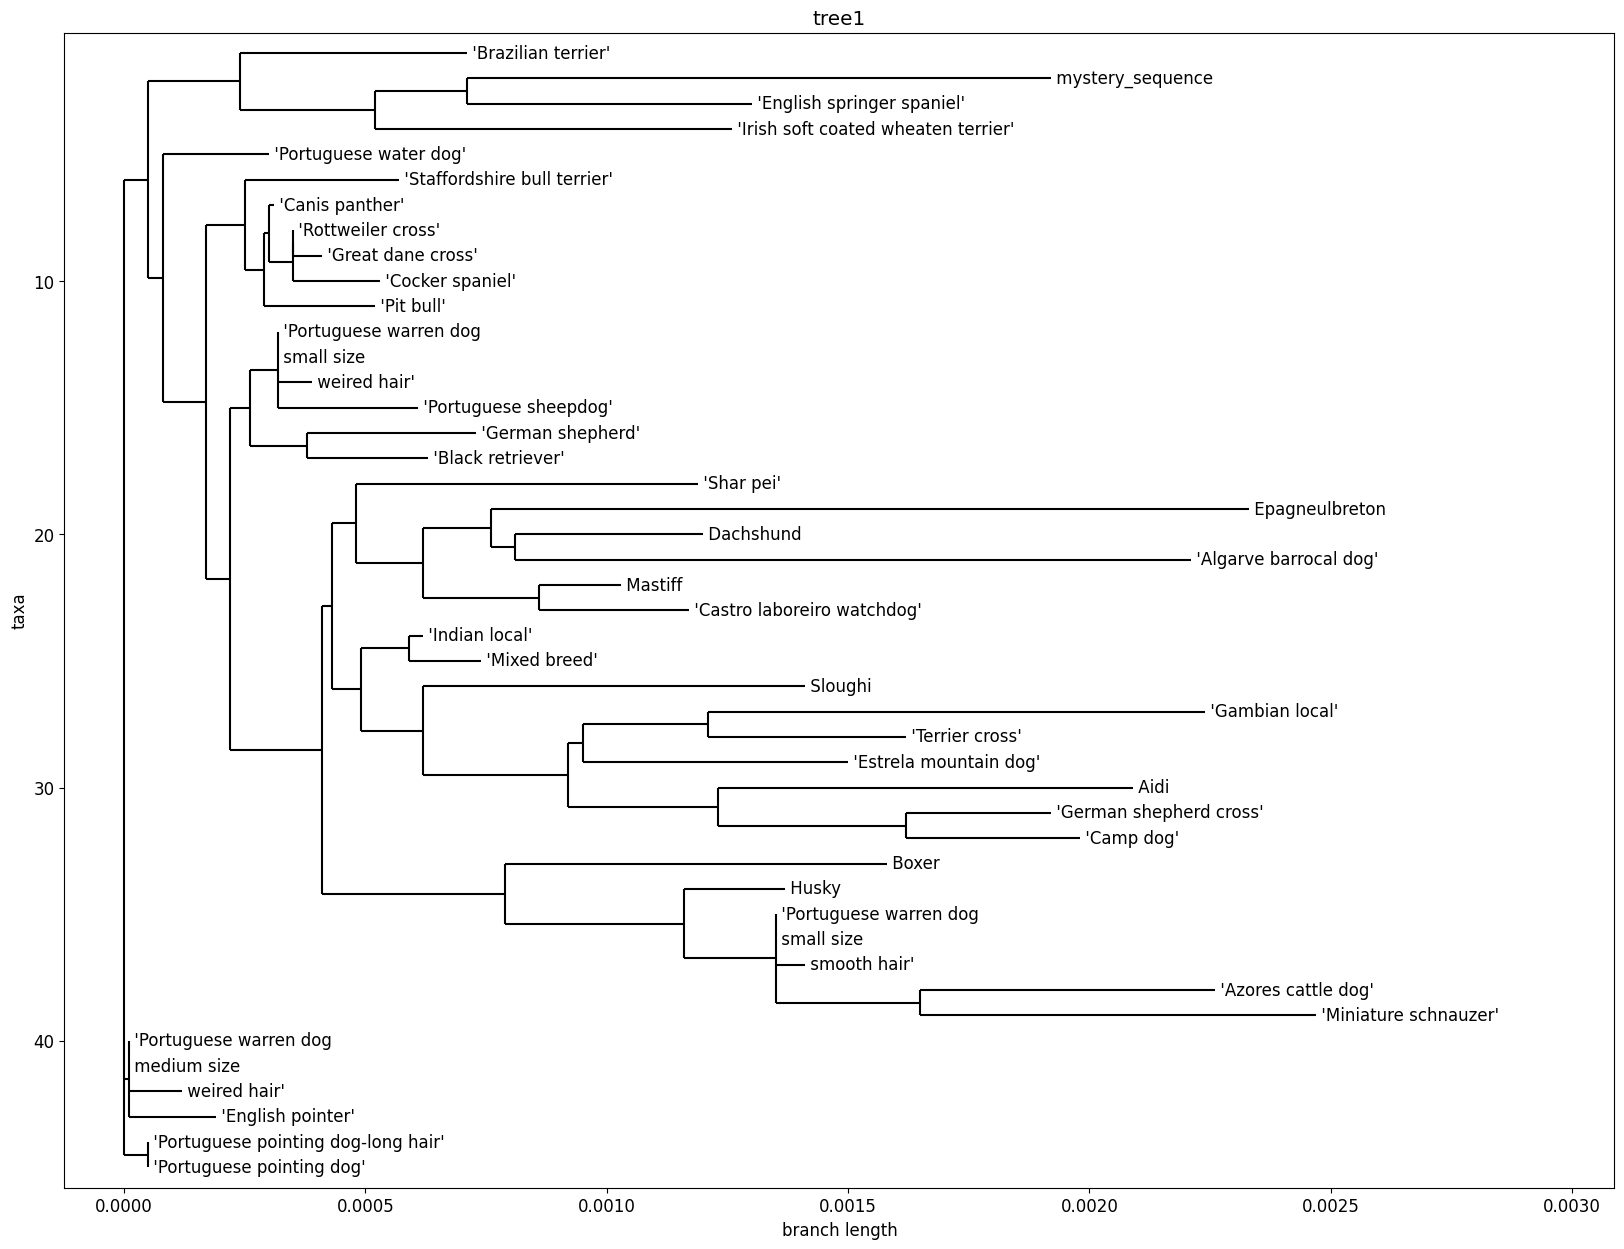

In [21]:
breeds_nex = Phylo.read("breeds_tree.nex", "nexus")
breeds_nex.rooted = True
# Create a custom label function that returns None for inner clade labels
def custom_label_func(node):
    if node.is_terminal():
        return node.name
    else:
        return None
import matplotlib
fig = plt.figure(figsize=(20,15), dpi=100, frameon=False)
matplotlib.rc("font", size=12)
ax = plt.gca()
Phylo.draw(breeds_nex, show_confidence=True, axes=ax, label_func=custom_label_func)


In [28]:
#create a graph for each 100 bases long sequence alignment figure 
from pymsaviz import MsaViz
read_alignment = AlignIO.read(f"{output}/top_alignment_output", "clustal")  

l = len(top_alignment[0]) 
mv = MsaViz(read_alignment, format="clustal", start=1, end=l, wrap_length=100)
mv.savefig(f"{output}/top_alignment_image")



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
#make a plot to represent the conservation levels of the MSA

MSA_alignment = AlignIO.read(f"{output}/MSA_alignment", "clustal")  

l = len(MSA_alignment[0]) 
mv = MsaViz(read_alignment, format="clustal", start=1, end=l, wrap_length=100, show_consensus=True)
mv.savefig(f"{output}/top_alignment_image")
